In [18]:
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor)
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer, RobustScaler)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, KFold)
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Matlab-style plotting
import time
import AveragedModels as av
import xgboost as xgb
import lightgbm as lgb
import ml_helper2 as mlh

In [19]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [20]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


In [21]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


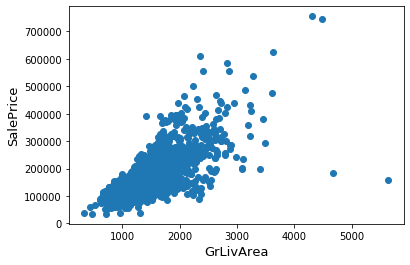

In [22]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [23]:
def scatterPlot(df, X, Y, font=13):
    fig, ax = plt.subplots()
    ax.scatter(x = df[X], y = df[Y])
    plt.ylabel(Y, fontsize=13)
    plt.xlabel(X, fontsize=13)
    plt.show()
    
def crossValidateModel(model, X, y, name="<unknown>", threads = -1):
    start = time.time()
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train)
    scores = cross_val_score(model, X, y, scoring = "neg_mean_absolute_error", n_jobs = threads, verbose = 4, cv = kf)
    end = time.time()
    elapsed_time = end - start
    print("model {0} cross_val_score took {1} seconds".format(name, elapsed_time))
    displayScores(-scores)
    
def displayScores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("standard deviation:", scores.std())

In [24]:
train, outliers = mlh.outlierDetect_ZScore(train, zValue = 9)
print(train.shape)

number of outliers = 29
(1434, 80)


E:\pythonProjects\PythonProjects\housingPrices\HousingPrices\ml_helper2.py:25: RuntimeWarning: invalid value encountered in greater
  outliers = np.where(z > zValue)


In [25]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test), sort = False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2893, 79)


In [26]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.896301
MiscFeature,96.577947
Alley,93.190460
Fence,80.608365
FireplaceQu,48.772900
LotFrontage,16.522641
GarageFinish,5.357760
GarageYrBlt,5.357760
GarageQual,5.357760
GarageCond,5.357760


In [27]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [28]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = all_data.select_dtypes(exclude=object) 
num_features_names = numeric_features.columns

# features that need a log transformation
log_features_names = ["LotFrontage", "LotArea", "GrLivArea", "OpenPorchSF"]

log_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', FunctionTransformer(np.log1p, validate=False)),
    ('logscaler', RobustScaler())])

#kbinDiscretizer features
year_features_names = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
year_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('kbd', KBinsDiscretizer(n_bins=5, encode='onehot-dense'))])

#numeric features that require a normal transformation

numeric_features_names = [x for x in num_features_names if x not in log_features_names + year_features_names]
print(len(numeric_features_names))

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features_names = all_data.select_dtypes(include=object).columns

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformers=[
        ('log', log_pipeline, log_features_names),
        ('num', numeric_pipeline, numeric_features_names),
        ('cat', cat_pipeline, categorical_features_names),
        ('year', year_pipeline, year_features_names)     
    ]

ct = ColumnTransformer(transformers=transformers)
Xt = ct.fit_transform(all_data)
print(Xt.shape)

28
(2893, 311)


c:\users\rajes\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [29]:
#fitting and prediction
train = Xt[:ntrain]
test = Xt[ntrain:]

In [35]:
# try xgboost\n",
xgb_model = xgb.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                            learning_rate=0.05, max_depth=5,
                              min_child_weight=1.8, n_estimators=500,
                               reg_alpha=0.9, reg_lambda=0.9, gamma=0.001, 
                              silent=1, random_state =7, nthread = -1, refit = True)

crossValidateModel(xgb_model, train, y_train, "xgb")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s


model xgb cross_val_score took 13.152648448944092 seconds
Scores: [14178.79322735 16274.3133983  16269.34389972 13748.07450457
 14578.36834845]
Mean: 15009.77867567836
standard deviation: 1063.400368580126


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s finished


In [32]:
# Set the parameters by cross-validation
param_grid = [{'colsample_bytree': [0.3, 0.5, 0.8, 0.9], 'gamma': [1e-3, 1e-2, 1e-1, 1],
                     'n_estimators': [500, 750, 1000]},
                    ]

grid_search = GridSearchCV(xgb_model, param_grid, scoring = "neg_mean_absolute_error", n_jobs = -1, verbose = 10, cv = 5)
grid_search.fit(train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0.01,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1.8, missing=None,
                                    n_estimators=700, n_jobs=1, nthread=-1,
                                    objective='reg:linear', random_state=7,
                                    refit=True, reg_alpha=0.9, reg_lambda=0.9,
                                    scale_pos_weight=1, seed=None, silent=1,
                                    subsample=0.5, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid=[{'colsample_bytree': [0.3, 0.5, 0.8, 0.9],
                          'gamma': 

In [34]:
grid_search.best_params_

{'colsample_bytree': 0.8, 'gamma': 0.001, 'n_estimators': 500}

In [31]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                 learning_rate=0.05, n_estimators=720,
                                 max_bin = 55, bagging_fraction = 0.8,
                                 bagging_freq = 5, feature_fraction = 0.2319,
                                 feature_fraction_seed=9, bagging_seed=9,
                                 min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

crossValidateModel(model_lgb, train, y_train, "lightgbm", 1) # 1 job

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ............................... , score=-14547.114, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... , score=-16495.071, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ............................... , score=-15839.676, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV] ............................... , score=-13679.437, total=   0.2s
[CV]  ................................................................
[CV] ............................... , score=-13827.800, total=   0.3s
model lightgbm cross_val_score took 1.301516056060791 seconds
Scores: [14547.11431369 16495.07133039 15839.67649522 13679.43743991
 13827.79979577]
Mean: 14877.819874996776
standard deviation: 1112.5375700278682


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [17]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)

crossValidateModel(GBoost, train, y_train, "gboost")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.3s remaining:   30.4s


model gboost cross_val_score took 33.46435308456421 seconds
Scores: [14099.48264972 16417.52633853 16053.67851183 12735.2849404
 14253.47610194]
Mean: 14711.889708484552
standard deviation: 1356.5946598774133


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished


In [16]:
averaged_models = av.AveragingModels(models = (GBoost, model_lgb, xgb_model))



NameError: name 'GBoost' is not defined

In [ ]:
averaged_models.fit(train, y_train)

#make predictions which we will submit. 
y_pred = averaged_models.predict(test)

#The lines below shows how to save predictions in format used for competition scoring
output = pd.DataFrame({'Id': test_ID,
                       'SalePrice': y_pred})
output.to_csv('../data/submission.csv', index=False)